# Captsone Project - Starbucks Offers
## Introduction
The data for this project was provided by Starbucks for the Udacity Data Scientist Nanodegree program.  It is simulated (rather than actual) data that mimics reward offers and customer purchasing behavior over a 30-day test period.

There are three questions that I would like to answer in this project:
1. What are the demographic groups?
2. Which offer is best for each demographic group?
3. Which delivery method is best for each offer/demographic group?

Three datasets are provided:

**portfolio.json**

Offers sent during a 30-day test period
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**

Rewards program users
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**

Event log
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [46]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# read in datasets
portfolio = pd.read_json('data/portfolio.json',orient='records',lines=True)
profile = pd.read_json('data/profile.json',orient='records',lines=True)
transcript = pd.read_json('data/transcript.json',orient='records',lines=True)

In [47]:
# Preview each dataframe and display the shape
display(portfolio.head())
print('portfolio shape:',portfolio.shape)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


portfolio shape: (10, 6)


In [48]:
display(profile.head())
print('profile shape:',profile.shape)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


profile shape: (17000, 5)


In [49]:
display(transcript.head())
print('transcript shape:',transcript.shape)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


transcript shape: (306534, 4)


## Data Exploration
Exploring the **portfolio** dataframe is easy because there are only 10 rows and 6 columns so the entire dataframe can be easily visualized.

In [50]:
# display the entire portfolio dataframe
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


There are 10 different offers: 4 bogo's, 4 discounts, and 2 informational types.  All of them use email as a channel, which means that including email doesn't provide a way to distinguish any of the offer types.  I can drop this value from the 'channels' feature to simplify the analysis.

For the **profile** dataframe, lets first look at null values.  Missing values in 'age' are represented by the value 118, while in 'gender' they are represented by the string 'None'.  I will map these values to NaN's and then count the null values in each column.

In [51]:
# Map 118 to NaN in 'Age' column
profile['age'] = profile['age'].apply(lambda x: np.nan if x==118 else x)

In [52]:
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [53]:
# Map 'None' to NaN in 'gender column'
profile['gender'] = profile['gender'].apply(lambda x: np.nan if x==None else x)
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,NaN,a03223e636434f42ac4c3df47e8bac43,NaN


In [54]:
# count the number of null values in each column of the profile dataframe
profile.isnull().sum()

age                 2175
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [55]:
# now count the number of rows with 3 null values
profile.isnull().sum(axis=1).value_counts()

0    14825
3     2175
dtype: int64

Of the 17,000 users in the **profile** dataset, 2,175 are missing age, gender, and income data while the remaining 14,825 users are not missing any demographic data.  The only identifying feature for the 2,175 users is the date they joined the Starbucks rewards program.  This could be a useful feature later in the analysis, but if it isn't, then I'll feel confident dropping the users with missing values since I'll still have a majority of the dataset with complete information.

I also want to visualize the demographic data and calculate some descriptive statistics for each demographic feature.

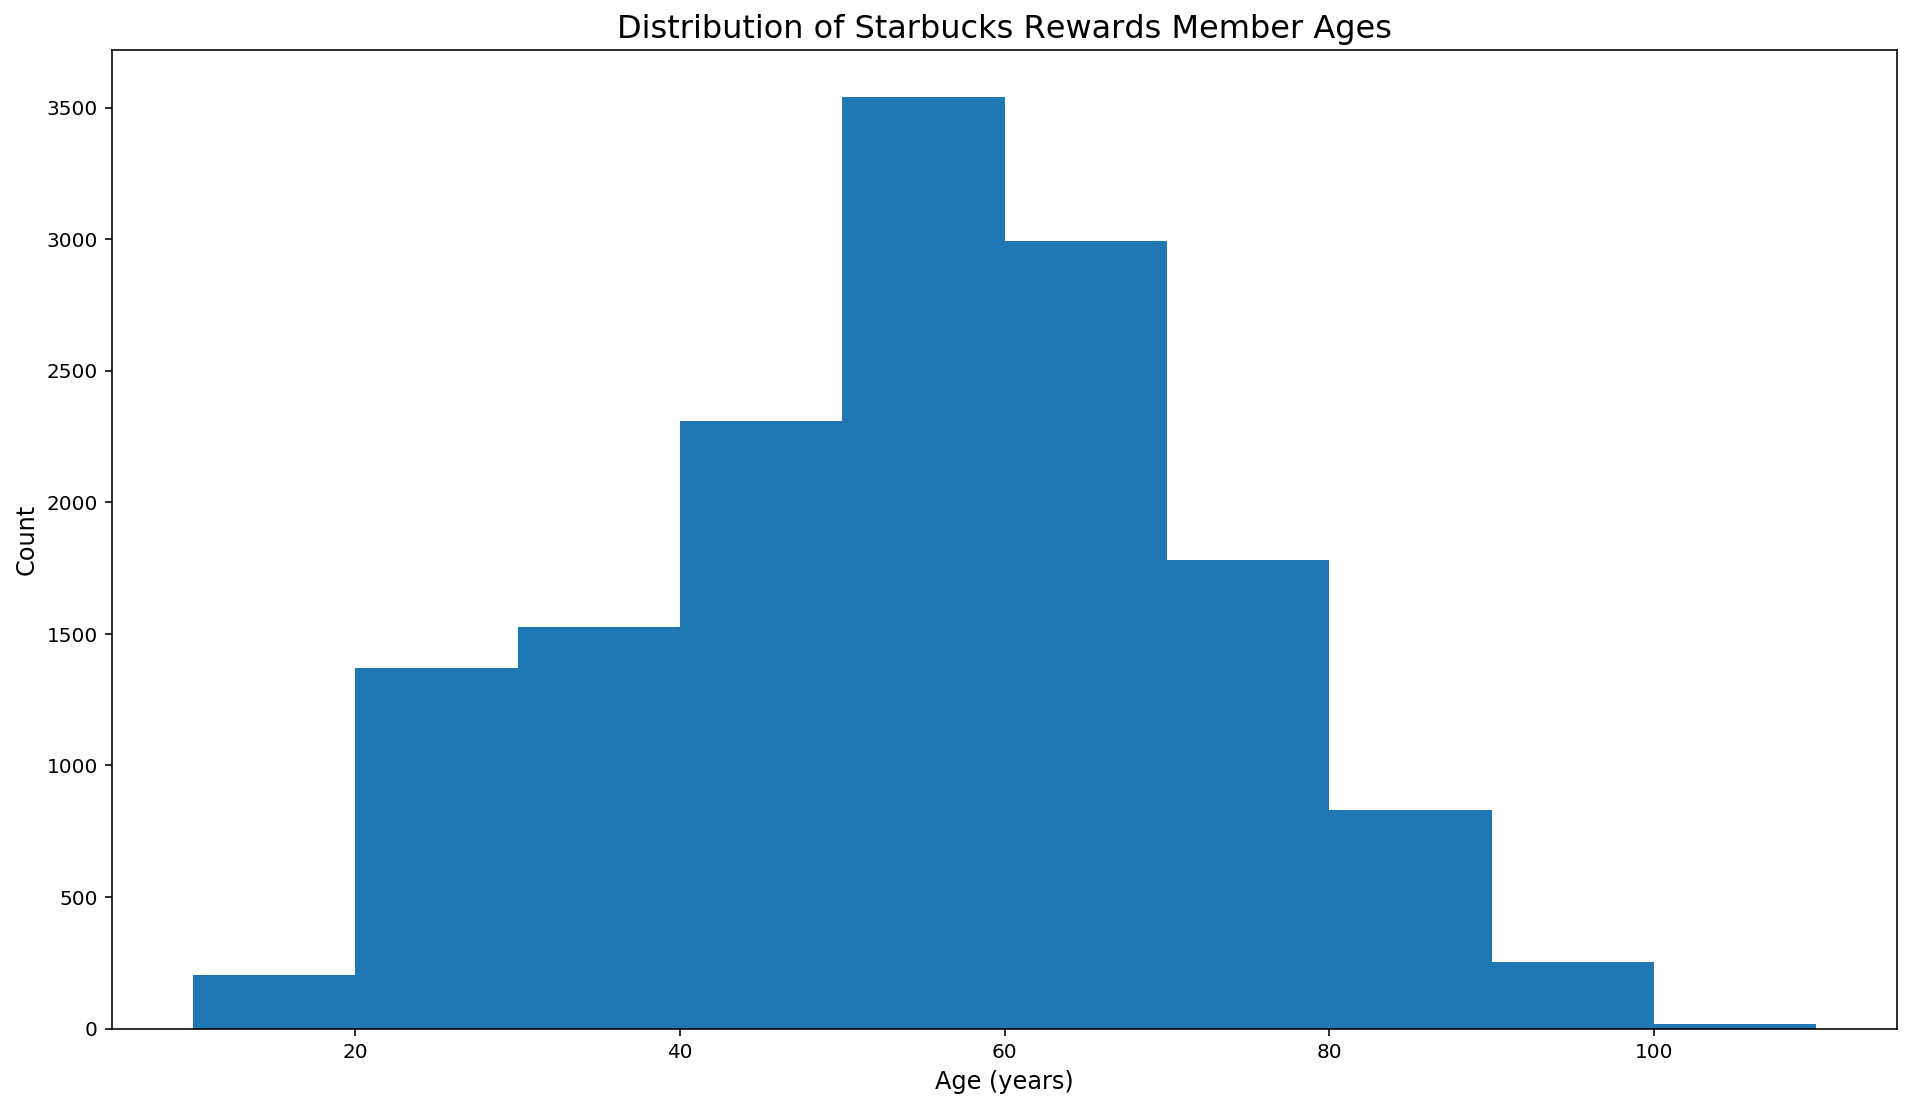

In [132]:
# plot a histogram of the 'age' feature
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(profile['age'],bins=range(10,120,10))
ax.set_xlabel('Age (years)',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
ax.set_title('Distribution of Starbucks Rewards Member Ages',fontsize=16)
plt.show()

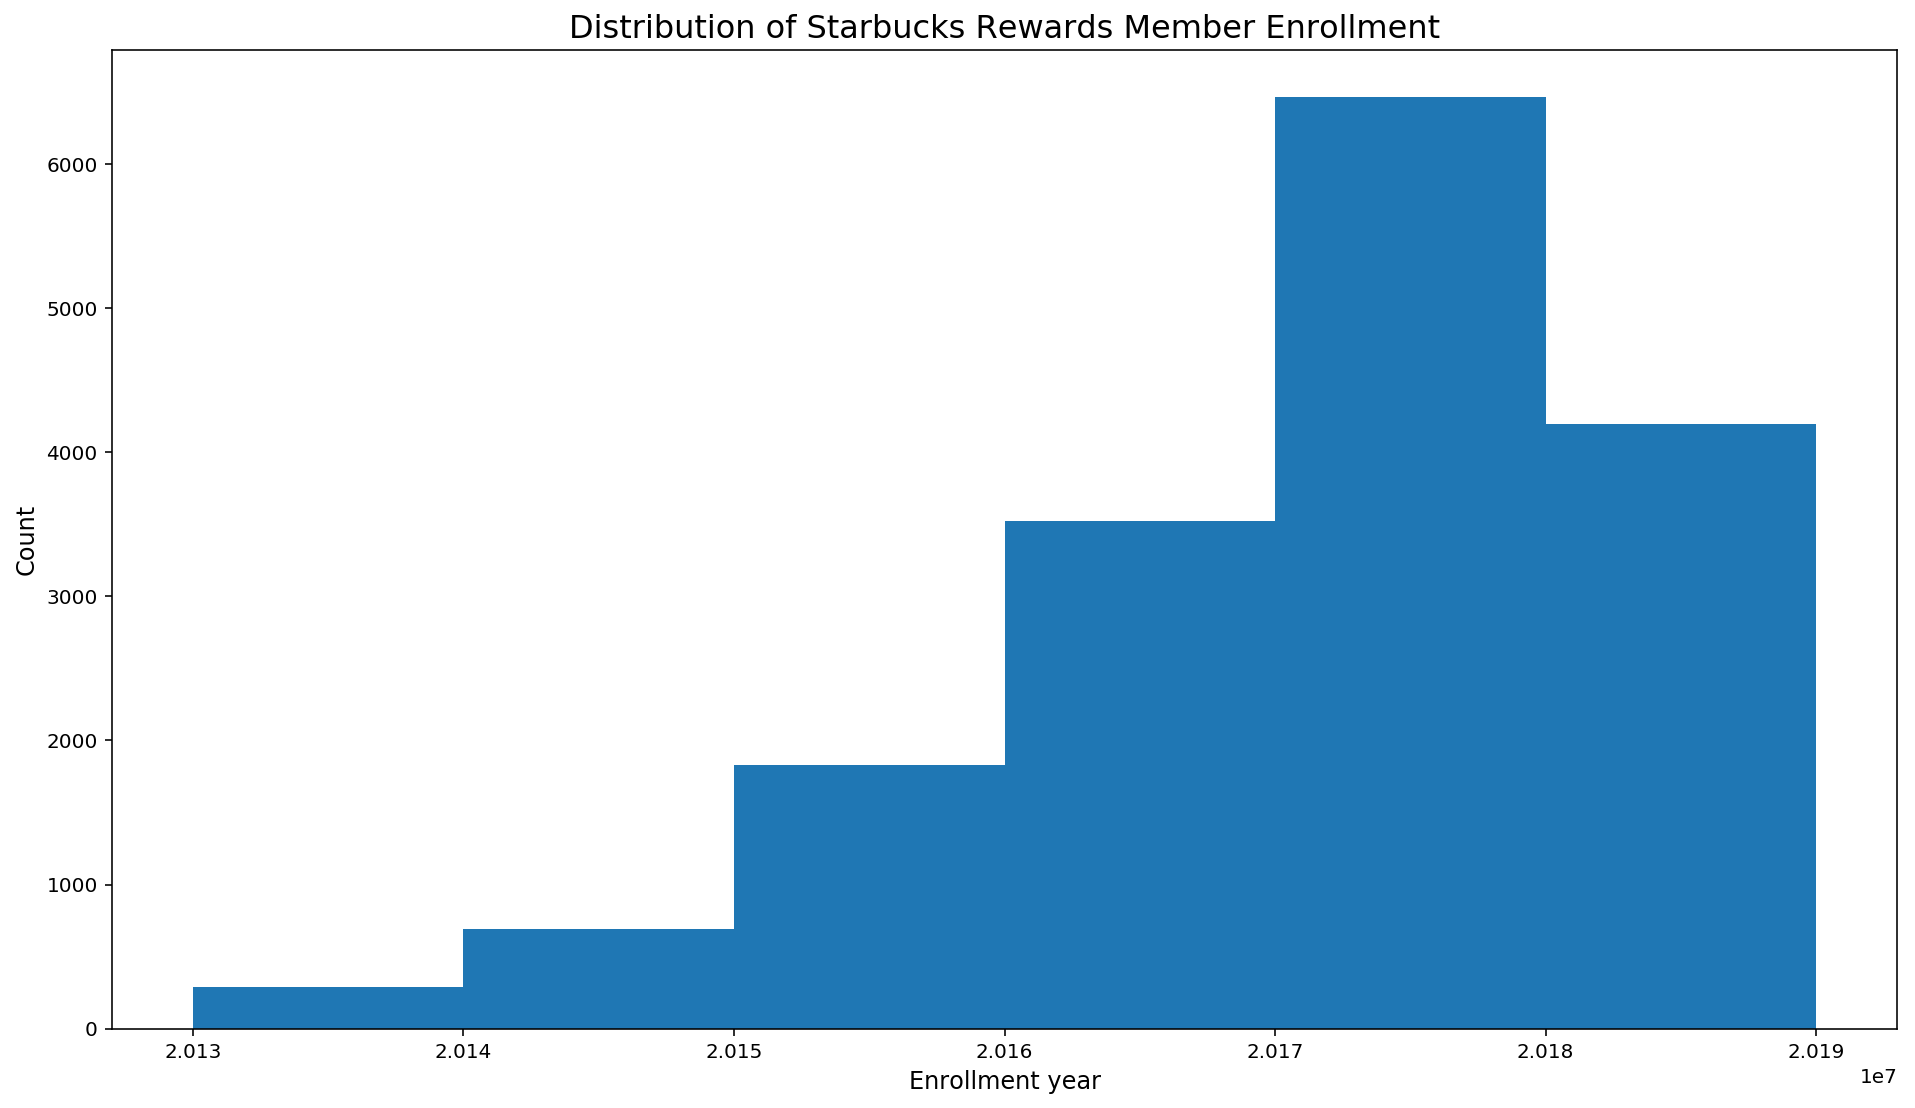

In [130]:
# plot a histogram of the 'became_member_on' feature
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(profile['became_member_on'],bins=range(20130000,20200000,10000))
ax.set_xticks(range(20130000,20200000,10000))
ax.set_xlabel('Enrollment year',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
ax.set_title('Distribution of Starbucks Rewards Member Enrollment',fontsize=16)
plt.show()

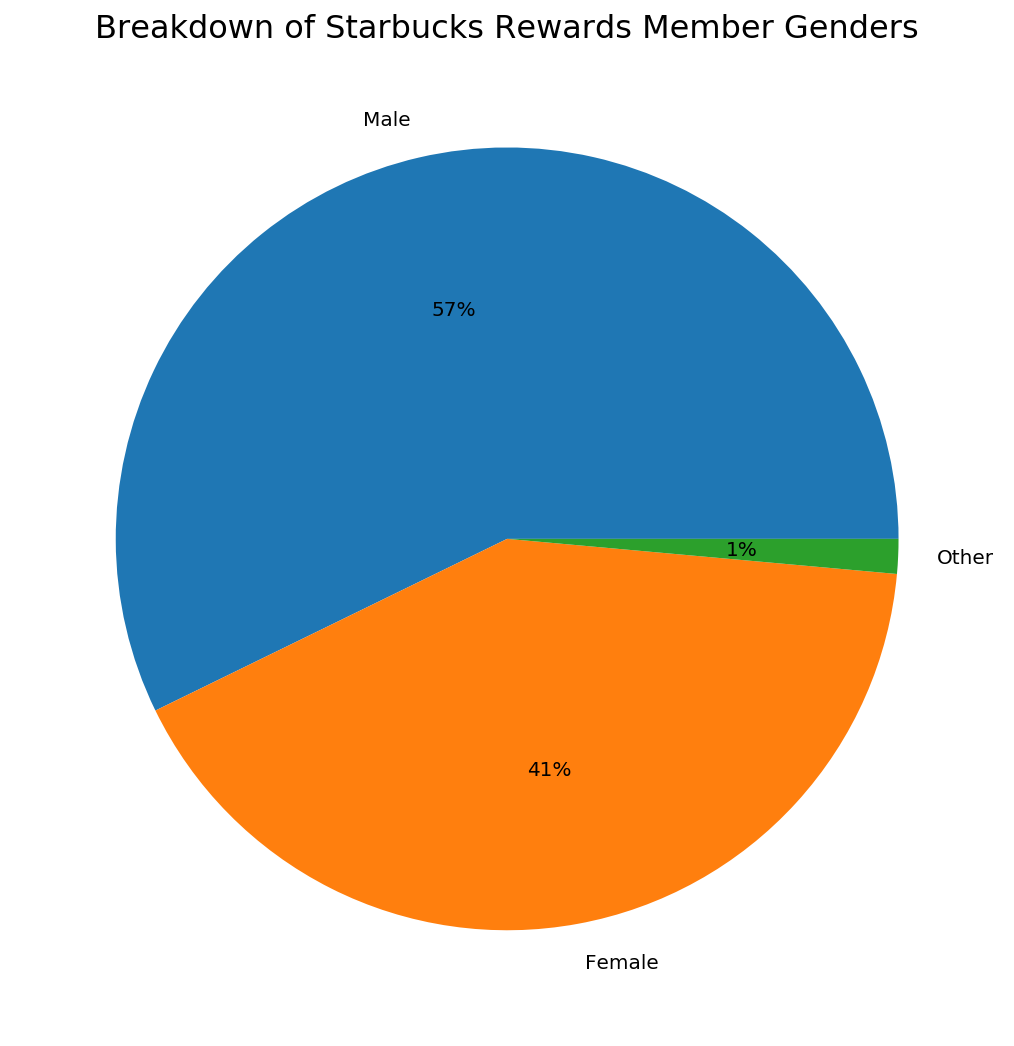

In [128]:
# plot a pie chart of the 'gender' feature
gender_labels = profile['gender'].value_counts().index.map({'M':'Male','F':'Female','O':'Other'})
fig, ax = plt.subplots(figsize=(16,9))
ax.pie(profile['gender'].value_counts(),labels=gender_labels,autopct='%1.f%%')
ax.set_title('Breakdown of Starbucks Rewards Member Genders',fontsize=16)
plt.show()

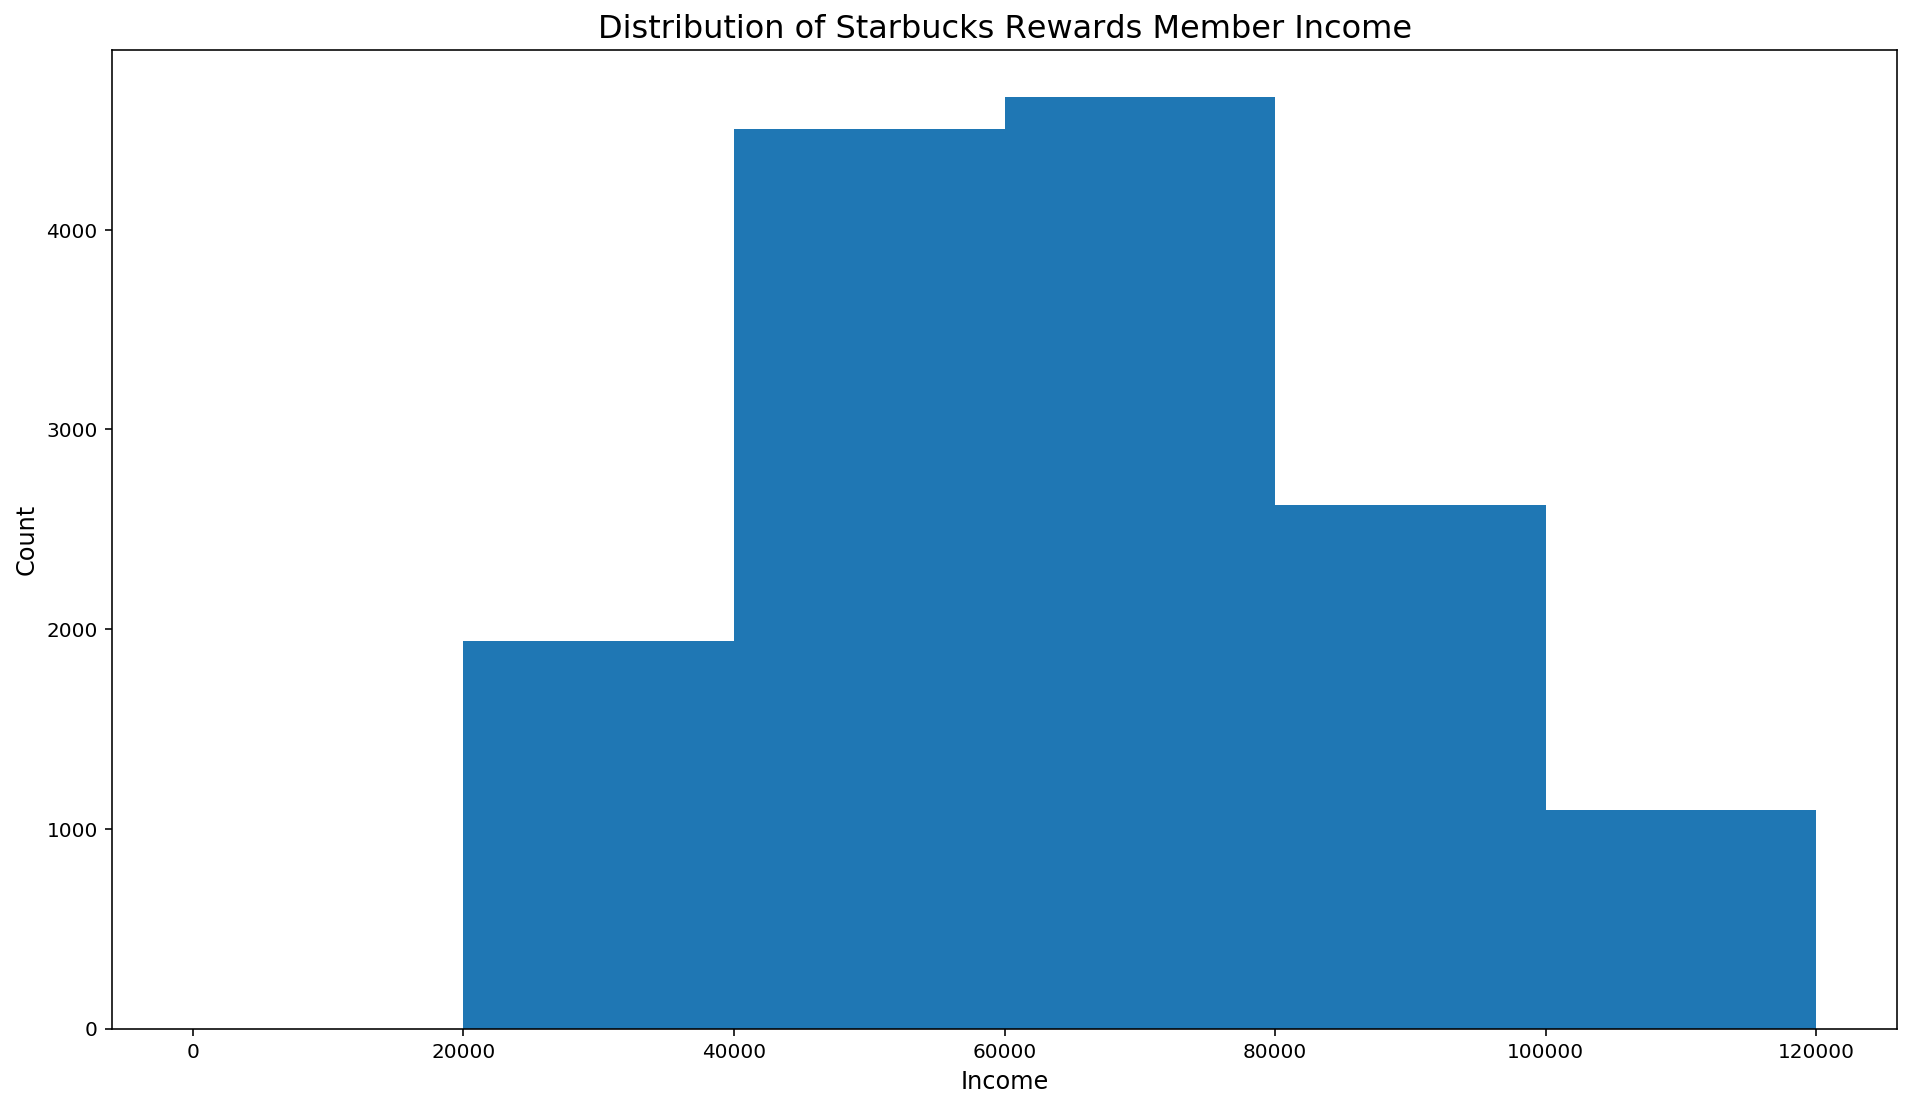

In [75]:
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(profile['income'],bins=range(0,140000,20000))
ax.set_xlabel('Income',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
ax.set_title('Distribution of Starbucks Rewards Member Income',fontsize=16)
plt.show()

In [129]:
# Generate descriptive statistics of the demographic data
profile.describe()

,age,became_member_on,income
count,14825.000000,1.700000e+04,14825.000000
mean,54.393524,2.016703e+07,65404.991568
std,17.383705,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016053e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


Visualizations and descriptive statistics of the demographic data in the **profile** dataset have given me a better understanding of the makeup of this user group.  The rewards members range in age from 18 to 101 years with a mean age of ~54 years.  The minimum age makes sense since it is likely an individual must be 18 years or older to join the rewards program, but I am a little surprised that there is a 101-year-old member and that the age distribution is centered around 55.  I expected the distribution to be centered around users in their 20s and 30s.  Member incomes range from $14,825 to $120,000 with a mean of ~$65,400, which falls in line with my expectations for income distribution in the U.S.  A majority (57\%) of members are male, which also surprised me since I expected it to be closer to a 50/50 split with female or skewed towards female consumers.  Finally, membership enrollment ranges from July 2013 to July 2018 with enrollment numbers increasing at an increasing rate from 2013 through 2017 before decreasing in 2018.  The decrease in 2018 is likely due to capturing an incomplete year of member enrollments.  This trend in enrollments indicates that the Starbucks Rewards program is increasing in popularity and therefore there is an opportunity to influence the purchasing behavior of a growing number of Starbucks customers with this project.

For the **transcript** dataset, I don't expect there to be any missing data since these records were generated during the experiment and should have been set up to record all relevant information.

In [38]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

As expected, there are no missing values in the **transcript** dataset.